In [28]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 
import random 
import networkx as nx 
import itertools 
import pickle 
from scipy.special import digamma
import timeit
import seaborn as sns 
import sklearn.metrics as metrics 
from Block_PLSA.utils_beta import draw_image_matrix,get_normalized_theta,get_sub_input,get_top_docs,get_top_tokens

# load data

In [2]:
# cora dataset
G_cora=nx.read_adjlist('data/Cora_enrich/idx_adjlist.txt',nodetype=int,create_using=nx.DiGraph)
# cora texts
texts_cora=np.loadtxt('data/Cora_enrich/BOW_texts_3876.txt',dtype=np.int)

In [3]:
with open('data/Cora_enrich/tokens_3876.pickle','rb') as f:
    tokens=pickle.load(f)
tokens=np.array(tokens)

labels=[]
with open('data/Cora_enrich/labels.txt') as f:
    for line in f:
        labels.append(line.strip())
labels=np.array(labels)

# Process input data 

In [4]:
set(labels)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [57]:
classes=['Neural_Networks','Genetic_Algorithms','Theory']

In [58]:
G_sub,labels_sub,texts_sub,_=get_sub_input(classes,G_cora,labels,texts_cora)

# PLSA 

## input transformation 

In [59]:
# transfer input to observed variables
# PLSA part
ii,jj=np.nonzero(texts_sub)
WS=np.repeat(jj,texts_sub[ii,jj])
DS=np.repeat(ii,texts_sub[ii,jj])

In [60]:
# help utils
D_ids={}
for idx,d in enumerate(DS):
    if d in D_ids:
        D_ids[d].append(idx)
    else:
        D_ids[d]=[idx]
        
W_ids={}
for idx,w in enumerate(WS):
    if w in W_ids:
        W_ids[w].append(idx)
    else:
        W_ids[w]=[idx]

## initialization

In [61]:
K=3
D=texts_sub.shape[0]
V=texts_sub.shape[1]
N=len(WS)
# runtime parameters
n_iter_EM=50
phi_max_gap=0.001

In [62]:
# Initialize EM parameters randomly (use diriclet to ensure normalization)
beta=1e-1

omega=np.zeros((K,D))
for k in range(K):
    omega[k,:]=stats.dirichlet.rvs(np.repeat(beta,D))
    
phi=np.zeros((K,V))
for k in range(K):
    phi[k,:]=stats.dirichlet.rvs(np.repeat(beta,V))
    
pi=stats.dirichlet.rvs(np.repeat(beta,K)).flatten()
    
# initialize VI parameters
epsilon=np.zeros((N,K))
for n in range(N):
    epsilon[n,:]=stats.dirichlet.rvs(np.repeat(beta,K))

In [63]:
# variational-EM
for it_em in range(n_iter_EM):
    # E-step
    # solve epsilon  
    for k in range(K):
        epsilon[:,k]=omega[k,DS[range(N)]]*phi[k,WS[range(N)]]*pi[k]
    epsilon=epsilon/epsilon.sum(axis=1)[:,np.newaxis]

    # M-step
    phi_last=phi.copy()
    pi_last=pi[:]
    omega_last=omega.copy() 
    # omega    
    for d in range(D):
        ep_id=D_ids.get(d,[])
        omega[:,d]=epsilon[ep_id,:].sum(axis=0)
    omega=omega/omega.sum(axis=1)[:,np.newaxis]

    # phi
    for w in range(V):
        ep_id=W_ids.get(w,[])
        phi[:,w]=epsilon[ep_id,:].sum(axis=0)
    phi=phi/phi.sum(axis=1)[:,np.newaxis]
    
    # pi
    pi=epsilon.sum(axis=0)
    pi=pi/pi.sum()
    # check convergence
    phi_gap=np.abs(phi-phi_last).sum()
    pi_gap=np.abs(pi-pi_last).sum()
    omega_gap=np.abs(omega-omega_last).sum() 
    print('iter:%d,phi_gap:%f,pi_gap:%f,omega_gap:%f'%(it_em,phi_gap,pi_gap,omega_gap))
    if phi_gap<phi_max_gap:
        break                

iter:0,phi_gap:4.593371,pi_gap:0.814346,omega_gap:4.281663
iter:1,phi_gap:0.451537,pi_gap:0.005533,omega_gap:0.450528
iter:2,phi_gap:0.249629,pi_gap:0.002917,omega_gap:0.235100
iter:3,phi_gap:0.175233,pi_gap:0.001946,omega_gap:0.160055
iter:4,phi_gap:0.143915,pi_gap:0.002110,omega_gap:0.130549
iter:5,phi_gap:0.131940,pi_gap:0.002427,omega_gap:0.120979
iter:6,phi_gap:0.129697,pi_gap:0.002846,omega_gap:0.120325
iter:7,phi_gap:0.131704,pi_gap:0.003382,omega_gap:0.123270
iter:8,phi_gap:0.134981,pi_gap:0.003927,omega_gap:0.127381
iter:9,phi_gap:0.137006,pi_gap:0.004230,omega_gap:0.130106
iter:10,phi_gap:0.136094,pi_gap:0.004171,omega_gap:0.129594
iter:11,phi_gap:0.131991,pi_gap:0.003982,omega_gap:0.126928
iter:12,phi_gap:0.126324,pi_gap:0.004022,omega_gap:0.123481
iter:13,phi_gap:0.120302,pi_gap:0.004131,omega_gap:0.119212
iter:14,phi_gap:0.113925,pi_gap:0.004059,omega_gap:0.114112
iter:15,phi_gap:0.108576,pi_gap:0.004124,omega_gap:0.109185
iter:16,phi_gap:0.103046,pi_gap:0.004161,omega_gap

## evaluation

In [64]:
get_top_tokens(phi,tokens,20)

[[('genet', 0.011443453118107681),
  ('program', 0.010588135440611232),
  ('ga', 0.00916355719471431),
  ('fit', 0.008265757092330872),
  ('popul', 0.00814605536282518),
  ('search', 0.007980494693829806),
  ('solut', 0.00763029714788847),
  ('oper', 0.007469306587717357),
  ('control', 0.007463485515618326),
  ('optim', 0.00634187677539266),
  ('select', 0.006093376486241516),
  ('perform', 0.006033790139420092),
  ('gp', 0.005897179930214909),
  ('crossov', 0.005486899046307891),
  ('work', 0.005278797717187295),
  ('individu', 0.004985836210216224),
  ('paper', 0.004957432422430706),
  ('number', 0.004837018086101751),
  ('point', 0.004802420405421494),
  ('implement', 0.004243521825552608)],
 [('network', 0.013481830995662495),
  ('train', 0.00896808593046625),
  ('data', 0.007811524811840889),
  ('class', 0.007169402098567783),
  ('error', 0.0064930713389916),
  ('time', 0.005966734084886703),
  ('tree', 0.0059070505254622705),
  ('number', 0.005568492369675423),
  ('case', 0.0053

In [65]:
get_top_docs(omega,labels_sub,10)

[[('Genetic_Algorithms', 0.015718248297831472),
  ('Genetic_Algorithms', 0.012299091147099863),
  ('Genetic_Algorithms', 0.011411207539917865),
  ('Genetic_Algorithms', 0.010583615698410181),
  ('Genetic_Algorithms', 0.010169553288437815),
  ('Genetic_Algorithms', 0.00950879611930661),
  ('Neural_Networks', 0.009182520694107176),
  ('Genetic_Algorithms', 0.007008732602248876),
  ('Genetic_Algorithms', 0.0068180188109922485),
  ('Neural_Networks', 0.006635236857057845)],
 [('Theory', 0.01426808443055911),
  ('Theory', 0.01151626137309912),
  ('Theory', 0.008268141517165952),
  ('Theory', 0.006804728110691406),
  ('Neural_Networks', 0.006503962542955819),
  ('Theory', 0.006417021940373834),
  ('Neural_Networks', 0.0054852922479820985),
  ('Neural_Networks', 0.004903016765420175),
  ('Theory', 0.004615554077613276),
  ('Neural_Networks', 0.004501767768784097)],
 [('Genetic_Algorithms', 0.15501995385587228),
  ('Neural_Networks', 0.04381041049911638),
  ('Neural_Networks', 0.01462923083820

In [14]:
pi 

array([0.23659647, 0.53218612, 0.23121741])

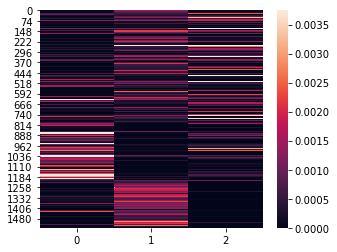

In [66]:
draw_image_matrix(omega,labels_sub,(5,4))

# BlockLDA

## utils 

In [16]:
def index2ij(index,K):
    row=int(index/K) 
    col=index%K
    return row,col 

## input transformation 

In [17]:
# blockmodel part
SS=[]
RS=[]
for e in G_sub.edges:
    SS.append(e[0])
    RS.append(e[1])
SS=np.array(SS,dtype=np.int)
RS=np.array(RS,dtype=np.int)

In [18]:
# help utils 
S_ids={}
for idx,s in enumerate(SS):
    if s in S_ids:
        S_ids[s].append(idx)
    else:
        S_ids[s]=[idx]
        
R_ids={}
for idx,r in enumerate(RS):
    if r in R_ids:
        R_ids[r].append(idx)
    else:
        R_ids[r]=[idx]

## initialization

In [19]:
# model hyperparameters 
alpha=1e-2
K=3
D=texts_sub.shape[0]
L=len(SS)

# runtime parameters
n_iter_VI=100
gamma_max_gap=0.001
verbose=10

In [20]:
# Initialize EM parameters randomly (use diriclet to ensure normalization)
beta=1e-1
    
# initialize VI parameters
gamma=stats.dirichlet.rvs(np.repeat(beta,K**2))

delta=np.zeros((L,K**2))
for l in range(L):
    delta[l,:]=stats.dirichlet.rvs(np.repeat(beta,K**2))

## start 

In [21]:
# VI with parameters from previous EM
for it_vi in range(n_iter_VI):
    gamma_last=gamma[:]
    # solve gamma&delta
    gamma=delta.sum(axis=0)+alpha

    for k in range(K**2):
        delta[:,k]=omega[index2ij(k,K)[0],SS[range(L)]]*omega[index2ij(k,K)[1],RS[range(L)]]*np.exp(digamma(gamma[k]))
    delta=delta/delta.sum(axis=1)[:,np.newaxis]
                
    # check convergence 
    gamma_gap=np.abs(gamma-gamma_last).sum()
    if it_vi%verbose==0:
        print('VI:%d,gamma_gap:%f'%(it_vi,gamma_gap)) 
        

VI:0,gamma_gap:2864.090000
VI:10,gamma_gap:2.615616
VI:20,gamma_gap:0.003624
VI:30,gamma_gap:0.000014
VI:40,gamma_gap:0.000000
VI:50,gamma_gap:0.000000
VI:60,gamma_gap:0.000000
VI:70,gamma_gap:0.000000
VI:80,gamma_gap:0.000000
VI:90,gamma_gap:0.000000


In [22]:
# derive expectation from posterior (variational) distribution
theta=gamma/gamma.sum()
theta=theta.reshape(K,K)

## evaluation

In [23]:
theta 

array([[3.09142349e-01, 3.49029175e-06, 3.49029175e-06],
       [5.23427464e-04, 4.99985985e-01, 5.35482798e-03],
       [3.49029175e-06, 3.49029175e-06, 1.84979450e-01]])

In [67]:
get_top_docs(omega,labels_sub)

[[('Genetic_Algorithms', 0.015718248297831472),
  ('Genetic_Algorithms', 0.012299091147099863),
  ('Genetic_Algorithms', 0.011411207539917865),
  ('Genetic_Algorithms', 0.010583615698410181),
  ('Genetic_Algorithms', 0.010169553288437815),
  ('Genetic_Algorithms', 0.00950879611930661),
  ('Neural_Networks', 0.009182520694107176),
  ('Genetic_Algorithms', 0.007008732602248876),
  ('Genetic_Algorithms', 0.0068180188109922485),
  ('Neural_Networks', 0.006635236857057845)],
 [('Theory', 0.01426808443055911),
  ('Theory', 0.01151626137309912),
  ('Theory', 0.008268141517165952),
  ('Theory', 0.006804728110691406),
  ('Neural_Networks', 0.006503962542955819),
  ('Theory', 0.006417021940373834),
  ('Neural_Networks', 0.0054852922479820985),
  ('Neural_Networks', 0.004903016765420175),
  ('Theory', 0.004615554077613276),
  ('Neural_Networks', 0.004501767768784097)],
 [('Genetic_Algorithms', 0.15501995385587228),
  ('Neural_Networks', 0.04381041049911638),
  ('Neural_Networks', 0.01462923083820

In [46]:
def get_cluster_results(omega):
    result=[]
    for i in range(omega.shape[1]):
        result.append(np.argmax(omega[:,i]))
    return result 

In [68]:
y_pred=get_cluster_results(omega)

In [69]:
metrics.adjusted_mutual_info_score(labels_sub,y_pred)

0.30618954973288354

In [70]:
metrics.normalized_mutual_info_score(labels_sub,y_pred)

0.30704716672713855

In [71]:
idx_class_dict={0:'Genetic_Algorithms',1:'Theory',2:'Neural_Networks'}

In [72]:
labels_pred=[idx_class_dict[i] for i in y_pred]

In [73]:
metrics.f1_score(labels_sub,labels_pred,average='macro')

0.6227082341703554

In [74]:
metrics.f1_score(labels_sub,labels_pred,average='micro')

0.61254851228978

In [75]:
metrics.f1_score(labels_sub,labels_pred,average='weighted')

0.59617984678837

In [76]:
metrics.accuracy_score(labels_sub,labels_pred)

0.61254851228978